# GWL - Simple  ELO Model Notebook

## Pipeline Summary  
The basic procedures contained within the notebook

import spreadsheet -> preprocess matches (columns in toydata) ->  
create elo class -> add players for teams-> init team dicts -> bymatch: expectation, gameOver, update dicts/rating ->  
massage final results into output format -> save output -> websitey stuff

## Imports  
All of the packages that will be used in this notebook

In [32]:
#imports
import openpyxl
import pandas as pd
import requests
import json
import math
import dataframe_image as dfi
import matplotlib.pyplot as plt
from io import BytesIO
from operator import itemgetter
pd.set_option("display.precision", 0)

## Import Spreadsheet data as a Pandas DataFrame

In [3]:
# Read in toy data spreadsheet tabs as separate dataframes in a list, season_data
spreadsheetId = "1HcmUMpPyTN3MwYlxGhms4OV3-gg4AbmrYimXM2eB4GY" # Please set your Spreadsheet ID for the current GWL week ######################################################
url = "https://docs.google.com/spreadsheets/export?exportFormat=xlsx&id=" + spreadsheetId
res = requests.get(url)
data = BytesIO(res.content)
xlsx = openpyxl.load_workbook(filename=data)
season_data = []
for name in xlsx.sheetnames:
    new_df = pd.read_excel(data, sheet_name=name)
    new_df.name = name
    season_data.append(new_df)

# Need to remove some rows in the Match Records, filter via rows where matches are played
matches = season_data[0]
matches = matches[matches['Played?'] == True]
season_data[0] = matches

In [4]:
matches.head(7)

,Tournament,Team 1,Team 2,IGNORE,Division?,Date,Time,Played?,Map1,Winner,...,Map6,Winner.5,Map7,Winner.6,Map8,Winner.7,Match Winner,VOD Link,Round #,MVP
0,Season,Awesome Anglers,Iceland Imps,DRAW,NaN,2022-06-05,22:00:00,1.0,Lijiang Tower,Iceland Imps,...,NaN,NaN,NaN,NaN,NaN,NaN,Iceland Imps,NaN,1.0,NaN
1,Season,Arizona O-Teas,Chicago Cats,DRAW,NaN,2022-06-05,20:00:00,1.0,Lijiang Tower,Arizona O-Teas,...,NaN,NaN,NaN,NaN,NaN,NaN,Arizona O-Teas,https://www.youtube.com/watch?v=BnxCKOBygwo,1.0,RiddleDog#1377
2,Season,Pokhara Pusheens,Welsh Whales,DRAW,NaN,2022-06-04,20:00:00,1.0,Lijiang Tower,Welsh Whales,...,NaN,NaN,NaN,NaN,NaN,NaN,Pokhara Pusheens,https://www.youtube.com/watch?v=XiF-vka40vU,1.0,PurpleJesus#11579
3,Season,Ema Skies,Troubling Trout,DRAW,NaN,2022-06-04,20:00:00,1.0,Lijiang Tower,Ema Skies,...,NaN,NaN,NaN,NaN,NaN,NaN,Ema Skies,NaN,1.0,NaN
4,Season,Dorado Ducks,Phiji Phrogs,DRAW,NaN,2022-06-05,20:00:00,1.0,Lijiang Tower,Phiji Phrogs,...,NaN,NaN,NaN,NaN,NaN,NaN,Dorado Ducks,https://www.youtube.com/watch?v=xzOBt_dUndg,1.0,NaN
5,Season,Awesome Anglers,Arizona O-Teas,DRAW,NaN,2022-06-10,20:00:00,1.0,Ilios,Awesome Anglers,...,NaN,NaN,NaN,NaN,NaN,NaN,Awesome Anglers,https://www.youtube.com/watch?v=08N6bXGUmT0,2.0,sonicronic#1848
6,Season,Iceland Imps,Pokhara Pusheens,DRAW,NaN,2022-06-11,20:00:00,1.0,Ilios,Iceland Imps,...,NaN,NaN,NaN,NaN,NaN,NaN,Iceland Imps,https://www.youtube.com/watch?v=wimk3B06Ujg,2.0,Syn#13108


## Define the simple Elo model classes and functions 

In [7]:
# Define ELO model
K = 125 # ELO update scaler
Rm = 3200 # default elo initialization
delta = 500 # scaler on rel(p(win|A,B), A-B) in elo calc's exponential (Q)

class Team:
    def __init__(self, name, Rm=3200):
        self.currentRating = Rm # Current estimate elo rating
        self.opponentHist = [] # sequence of opponents (weekly)
        self.ratingHist = [] # sequence of rating estimates (weekly)
        self.currentRanking = 11 # the team's current ranking among all teams (1-10 in GWL); 11 ~ unranked
        self.rankingHist = [] # sequence of team's standing (weekly)
        
class Elo:
    def __init__(self,Rm = 3200, k=125, g=1, delta=500):
        self.ratingDict = {} # dictionary of all teams and their current ratings; redundant/will be removed. currently accessed by power_rankings()
        self.teamsDict = {} # dictionary of all team objects and their attributes. this will be used for the json output
        self.k = k # k-factor for scaling max change in rating for a match
        self.g = g # g-factor, another modifier to the rating change; will be converted to a margin of victory at a later point.
        self.rankings = {} #  dictionary of the current power rankings; written-to by power_rankings()

    def addPlayer(self,name, Rm = 3200):
        self.ratingDict[name] = Rm # update code by deleting this and subsuming into teams dict
        self.teamsDict[name] = Team(name, Rm)

    def gameOver(self, winner, loser):
        # take single game, chop up number of maps & winner of each
        # combine all updates at once
        #   expectation =  expected score | number of maps & team elos
        #   diff = total map wins (+.5 for draws) - expectation
        result = self.expectResult(self.ratingDict[winner], self.ratingDict[loser]) # compute the expected result
        
        # redundancy
        self.ratingDict[winner] = self.ratingDict[winner] + (self.k*self.g)*(1 - result)  # update elo rating based on error
        self.ratingDict[loser] 	= self.ratingDict[loser] + (self.k*self.g)*(0 - (1 -result))
        
        self.teamsDict[winner].currentRating =  self.ratingDict[winner] + (self.k*self.g)*(1 - result)
        self.teamsDict[loser].currentRating = self.ratingDict[loser] + (self.k*self.g)*(0 - (1 -result))  
        
        # update the histories
        self.teamsDict[winner].opponentHist.append(loser) # update winner's opponent
        self.teamsDict[winner].ratingHist.append(self.teamsDict[winner].currentRating) # update winner's rating history
        #self.teamsDict[winner].rankingHist.append(self.teamsDict[winner].currentRanking) #  update winner's power ranking history
        self.teamsDict[loser].opponentHist.append(winner)
        self.teamsDict[loser].ratingHist.append(self.teamsDict[loser].currentRating)
        #self.teamsDict[loser].rankingHist.append(self.teamsDict[loser].currentRanking)
                                                                            

    def expectResult(self, p1, p2):
        exp = (p2-p1)/delta
        return 1/((10.0**(exp))+1)
    
    def update_rankings(self):
        r = 1
        rankings  = []
        for ranking in self.power_rankings():
            team = ranking[1][0]
            self.teamsDict[team].currentRanking = r  #  update  the current ranking
            self.teamsDict[team].rankingHist.append(self.teamsDict[team].currentRanking) # update the ranking history with the new ranking
            rankings.append(r)
            r += 1
        return rankings

    def power_rankings(self):
        self.rankings = sorted(self.ratingDict.items(), key=itemgetter(1), reverse=True)
        power = []
        for i, x in enumerate(self.rankings):
            power.append((i + 1, x))
        return power

## Model Implementation/ Testing

**MACRO TEST**


In [8]:
# initialize the elo model
GWL = Elo()

# initialize teams
teams = ['Iceland Imps', 'Ema Skies', 'Arizona O-Teas', 'Troubling Trout', 'Dorado Ducks','Awesome Anglers','Phiji Phrogs','Pokhara Pusheens','Chicago Cats','Welsh Whales']
for team in teams:
    GWL.addPlayer(team)

week = 1
for i, game in matches.iterrows():
    # Identify winner and loser
    winner = game['Match Winner']
    if game['Team 1'] == winner:
        loser = game['Team 2']
    else:
         loser = game['Team 1']
    # update elo
    GWL.gameOver(winner,loser)
    if (game['Round #'] > week) or (i == len(matches)-1): # update the power rankings at the end of a week
        GWL.update_rankings()
        week +=1
#vars(GWL.teamsDict['A'])
#GWL.update_rankings()
#GWL.teamsDict['A'].rankingHist

## Output and save model results

In [9]:
# NEXT STEP: MASSAGE OUTPUT INTO FORMAT WE WANT (json)
TeamsJSON = {}
for team in GWL.teamsDict:
    teamJSON = json.dumps(GWL.teamsDict[team].__dict__)
    TeamsJSON[team] = teamJSON
TeamsJSON

{'Iceland Imps': '{"currentRating": 3387.5, "opponentHist": ["Awesome Anglers", "Pokhara Pusheens"], "ratingHist": [3325.0, 3387.5], "currentRanking": 1, "rankingHist": [1, 1]}',
 'Ema Skies': '{"currentRating": 3387.5, "opponentHist": ["Troubling Trout", "Dorado Ducks"], "ratingHist": [3325.0, 3387.5], "currentRanking": 2, "rankingHist": [2, 2]}',
 'Arizona O-Teas': '{"currentRating": 3102.4837500492786, "opponentHist": ["Chicago Cats", "Awesome Anglers"], "ratingHist": [3325.0, 3102.4837500492786], "currentRanking": 8, "rankingHist": [6, 8]}',
 'Troubling Trout': '{"currentRating": 3262.5, "opponentHist": ["Ema Skies", "Welsh Whales"], "ratingHist": [3075.0, 3262.5], "currentRanking": 4, "rankingHist": [7, 4]}',
 'Dorado Ducks': '{"currentRating": 3137.5, "opponentHist": ["Phiji Phrogs", "Ema Skies"], "ratingHist": [3325.0, 3137.5], "currentRanking": 5, "rankingHist": [3, 5]}',
 'Awesome Anglers': '{"currentRating": 3297.5162499507214, "opponentHist": ["Iceland Imps", "Arizona O-Teas

In [10]:
# To  Access the nested dicitonary requires the use of json.loads() and the team name (key) to be loaded
json.loads(TeamsJSON['Iceland Imps'])

{'currentRating': 3387.5,
 'opponentHist': ['Awesome Anglers', 'Pokhara Pusheens'],
 'ratingHist': [3325.0, 3387.5],
 'currentRanking': 1,
 'rankingHist': [1, 1]}

In [11]:
# write out a json file.
with open('GWLweek2output.json', 'w') as outfile:
    json.dump(TeamsJSON,outfile)   

In [12]:
# A quick check to see that the output is correct:
with open('GWLweek2output.json') as json_file:
    data = json.load(json_file)
    print(data)

{'Iceland Imps': '{"currentRating": 3387.5, "opponentHist": ["Awesome Anglers", "Pokhara Pusheens"], "ratingHist": [3325.0, 3387.5], "currentRanking": 1, "rankingHist": [1, 1]}', 'Ema Skies': '{"currentRating": 3387.5, "opponentHist": ["Troubling Trout", "Dorado Ducks"], "ratingHist": [3325.0, 3387.5], "currentRanking": 2, "rankingHist": [2, 2]}', 'Arizona O-Teas': '{"currentRating": 3102.4837500492786, "opponentHist": ["Chicago Cats", "Awesome Anglers"], "ratingHist": [3325.0, 3102.4837500492786], "currentRanking": 8, "rankingHist": [6, 8]}', 'Troubling Trout': '{"currentRating": 3262.5, "opponentHist": ["Ema Skies", "Welsh Whales"], "ratingHist": [3075.0, 3262.5], "currentRanking": 4, "rankingHist": [7, 4]}', 'Dorado Ducks': '{"currentRating": 3137.5, "opponentHist": ["Phiji Phrogs", "Ema Skies"], "ratingHist": [3325.0, 3137.5], "currentRanking": 5, "rankingHist": [3, 5]}', 'Awesome Anglers': '{"currentRating": 3297.5162499507214, "opponentHist": ["Iceland Imps", "Arizona O-Teas"], "

### This output looks good for a json file!

## Visualization

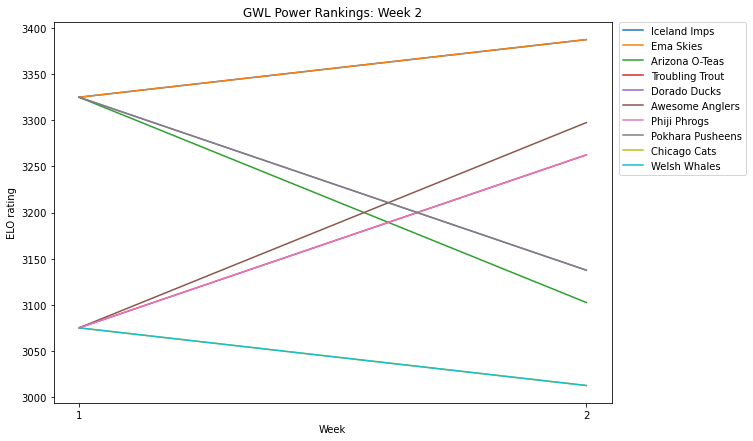

In [13]:
# Figure for Elo rating history
n_weeks =  len(GWL.teamsDict['Iceland Imps'].ratingHist)
title = 'GWL Power Rankings: Week {}'.format(n_weeks)
xlab = 'Week'
ylab = 'ELO rating'

# Maybe make a table for team colors

for team in GWL.teamsDict:
    plt.plot(GWL.teamsDict[team].ratingHist, label=team); # need line colors
#to include: figure sizes
fig = plt.gcf();
fig.set_size_inches(10,7);
plt.title(title);
plt.xlabel(xlab);
plt.ylabel(ylab);
plt.xticks(list(range(n_weeks)),list(range(1,n_weeks+1)));
plt.legend(loc='right',bbox_to_anchor = (1.25,.8));
#plt.savefig('elo_histories.png'); # uncomment to save figure

In [39]:
# Table for power rankings

#  First, to create a dataframe which will contain the data for the table
# initialize dataframe for 10 slots and labels 1-10, column names
power_table = pd.DataFrame(index = pd.RangeIndex(1,11,name='Rank'), columns = [' ','Team', 'ELO rating', '  '])

# iterate over each team and fill in their row of the dataframe
for team in GWL.teamsDict:
    r = GWL.teamsDict[team].currentRanking # team's ranking
    rr  = power_table.loc[r] # row for team's ranking
    
    # calculate ranking change
    dr =  GWL.teamsDict[team].rankingHist[-2] - GWL.teamsDict[team].currentRanking
    
    # calculate rating change
    dELO = round(GWL.teamsDict[team].currentRating - GWL.teamsDict[team].ratingHist[-2])
    
    # update power_table with team's values
    # ranking change
    if dr > 0:
        rr[0] = '+{}'.format(dr)
    elif dr == 0:
        rr[0] = ' '
    else:
        rr[0] = dr
    # team name
    rr[1] = team
    # ELO rating
    rr[2] = round(GWL.teamsDict[team].currentRating)
    # ELO change
    if  dELO  >0:
        rr[3] = '+{}'.format(dELO)
    elif dELO  == 0:
        rr[3] = '   '
    else:
        rr[3] = dELO
df_styled = power_table.style.background_gradient(); # may want to do more  styling/sizing here and in next line
dfi.export(df_styled,"GWLweek2power_rankings.png");  # uncomment to save table
df_styled

C:\Users\Rory\anaconda3\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


,,Team,ELO rating,
Rank,,,,
1,,Iceland Imps,3388,+62
2,,Ema Skies,3388,+62
3,+2,Awesome Anglers,3298,+223
4,+3,Troubling Trout,3262,+188
5,-2,Dorado Ducks,3138,-188
6,+2,Phiji Phrogs,3262,+188
7,-3,Pokhara Pusheens,3138,-188
8,-2,Arizona O-Teas,3102,-223
9,,Chicago Cats,3012,-62


In [15]:
# A quick  chunk of code just to check that rankings/ratings are ok
# for team in GWL.teamsDict:
#     r = GWL.teamsDict[team].currentRanking # team's ranking
#     rr  = power_table.loc[r] # row for team's ranking
    
#     # calculate ranking change
#     dr =  GWL.teamsDict[team].rankingHist[-2] - GWL.teamsDict[team].currentRanking
    
#     # calculate rating change
#     dELO = round(GWL.teamsDict[team].currentRating - GWL.teamsDict[team].ratingHist[-2])
    
#     prior_rating = GWL.teamsDict[team].ratingHist[-2]
#     prior_rank = GWL.teamsDict[team].rankingHist[-2]
#     print('current rank: {}, '.format(r) +'prior rank: {} \n'.format(prior_rank) + 'change: {} '.format(dr) + 'len games: {}'.format(len(GWL.teamsDict[team].rankingHist)))

In [38]:
# Next week match  preds table
# Want table with columns for team 1 /2 : ELO, rank, likelihood of victory
nweek_preds =  pd.DataFrame(columns= ['Rank', 'Team', '% Win', '% Win ', 'Team ', 'Rank ']);

# List of teams  for next week in order of Team 1  vs Team 2, Team 3 vs Team 4, etc...
nweek_teams = ['Pokhara Pusheens','Chicago Cats','Iceland Imps','Arizona O-Teas','Awesome Anglers','Ema Skies','Welsh Whales','Phiji Phrogs','Troubling Trout','Dorado Ducks']
# get the ranks for each
nweek_ranks  = []
for team in nweek_teams:
    nweek_ranks.append(GWL.teamsDict[team].currentRanking)
# compute the likelihoods
odds = []
teamnum = 0
for team  in nweek_teams:
    if (teamnum % 2)  == 0: #if even
        odds.append(int(round(100*GWL.expectResult(GWL.teamsDict[team].currentRating,GWL.teamsDict[nweek_teams[teamnum+1]].currentRating))))
        teamnum += 1
    else:
        odds.append(int(round(100*GWL.expectResult(GWL.teamsDict[team].currentRating,GWL.teamsDict[nweek_teams[teamnum-1]].currentRating))))
        teamnum += 1
# fill in the dataframe with the appropriate info from the lists
for mnum in range(int((len(nweek_teams)+1)/2)):
    t1num = mnum*2
    t2num = mnum*2+1
    nweek_preds.loc[mnum,:] = [nweek_ranks[t1num],nweek_teams[t1num],odds[t1num],odds[t2num],nweek_teams[t2num],nweek_ranks[t2num]]
#preds_styled = nweek_preds.style.background_gradient();
preds_styled = nweek_preds.style.hide_index();
dfi.export(preds_styled,"nweek_preds.png");  # uncomment to save table
preds_styled

C:\Users\Rory\AppData\Local\Temp\ipykernel_2128\540545846.py:27: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  preds_styled = nweek_preds.style.hide_index();
C:\Users\Rory\anaconda3\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


Rank,Team,% Win,% Win,Team,Rank
7,Pokhara Pusheens,64,36,Chicago Cats,9
1,Iceland Imps,79,21,Arizona O-Teas,8
3,Awesome Anglers,40,60,Ema Skies,2
10,Welsh Whales,24,76,Phiji Phrogs,6
4,Troubling Trout,64,36,Dorado Ducks,5


In [1]:
# Create Match predictions - Map score likelihoods table, when model is updated to map  score

##  To Do's: 
- make graphs look better (e.g. minor  offsets, line colors, etc)